<a href="https://colab.research.google.com/github/Folia412/Data_Analysis_2023/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
import os, io, random
import string
import re
import keras
from keras import layers
import tensorflow as tf

### 1 task

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
with io.open('/content/Aivengo_1411749087.txt', encoding="utf-8") as f:
    text = f.read().lower()
text = text.replace("\n", " ")
print("Corpus length:", len(text))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Corpus length: 771532


In [ ]:
chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Total chars: 86


In [ ]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 257164


In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
epochs = 1
batch_size = 128

for epoch in range(epochs):
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""
        sentence = text[start_index : start_index + maxlen]
        print('...Generating with seed: "' + sentence + '"')

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

2010/2010 [==============================] - 231s 114ms/step - loss: 2.2546

Generating text after epoch: 0
...Diversity: 0.2
...Generating with seed: ".  — то ми скористаємося вашою поважною "
...Generated:  поверності в своїх поронними за на на перед нашого в на на вдерно принц джон на від нав нев нев на від на перемовли в порочиння про невати в своїх про те на від нашим запитав на на на на на принц джон поверностю поверностю в своєю було було на поверності в своїх дового почання про вислиностю в порочиння поверності в порочиння за не пронц джон на в нього в полони в на на від нашими про те за нашими
-
...Diversity: 0.5
...Generating with seed: ".  — то ми скористаємося вашою поважною "
...Generated:  дроб невене, — сказав на скажен кращели, — відповів про свого видав де брасі, — про може те може він витали прийслу поваючи в за почерні в полонини на на паверне в свого пострими за на від пострібниць зе мажен поверною піднати в оголоч й побрати за вона в стін, що виконив за вона проїх 

### 2 task

In [28]:
from transformers import pipeline

sum_1 = pipeline("summarization", model="csebuetnlp/mT5_multilingual_XLSum")

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [39]:
text_1 = "Aladdin's lamp is a legendary magical artifact that gained prominence through Middle Eastern folklore and the collection of stories known as \"One Thousand and One Nights\" or \"Arabian Nights.\" According to the tale, Aladdin, a young man of humble origin, discovers a mysterious lamp containing a powerful genie capable of granting wishes. When Aladdin rubs the lamp, the genie appears, ready to fulfill the desires of its possessor. The lamp becomes a symbol of limitless possibilities and the transformative power of wishes. Aladdin's adventures, often associated with themes of love, wealth, and morality, have been retold and adapted in various cultures, cementing the lamp's place in global popular culture as an enduring symbol of magical possibilities."
result = sum_1(text_1, max_length=25, min_length=5)
print(result)

[{'summary_text': "Aladdin's lamp has become a symbol of limitless possibilities and power of wishes, according"}]


In [33]:
sum_2 = pipeline("summarization", model='ukr-models/uk-summarizer')

In [43]:
text_2 = "Килим з Аладдіна - це чарівний артефакт, який відомий завдяки своїм надприродним властивостям у казці \"Аладдін і чарівна лампа\". Згідно з легендою, коли Аладдін відкриває лампу, килим, який лежить поруч, стає засобом транспорту. Він підноситься в повітря та непомітно переносить свого володаря до будь-якого бажаного місця. Килим з Аладдіна володіє неабиякою інтелігенцією, виконуючи команди свого власника і реагуючи на його потреби. Цей чарівний килим став невід'ємною частиною світу казкових пригод і дивовижних подій, завойовуючи визнання читачів і глядачів своєю загадковістю та надзвичайними можливостями."
sum_2(text_2, max_length=28, min_length=5)

[{'summary_text': 'У сучасній казці "Аладдін і чарівна лампа" відомий чарівний килим з Ала'}]

###3 task

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
from keras.preprocessing import image

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_path = '0.jpg'
style_path = '1.jpg'

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

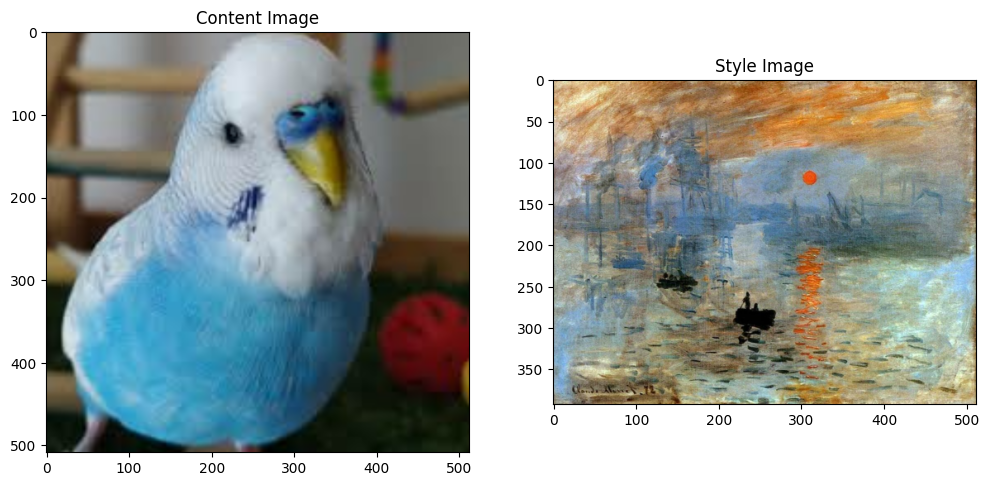

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [ ]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
style_weight=1e-2
content_weight=1e4
total_variation_weight=30

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

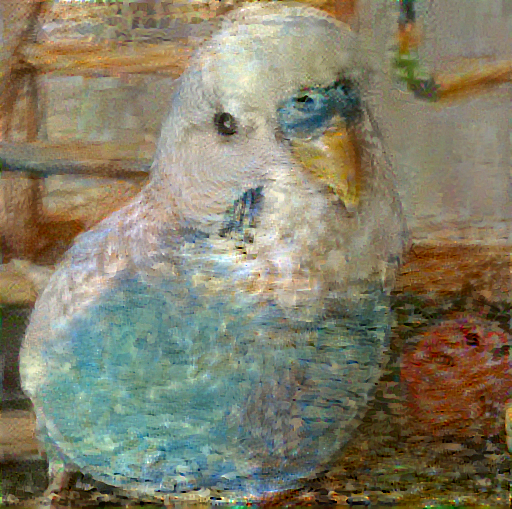

Train step: 200


In [ ]:
epochs = 2
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))